### AWS Tutorial

This tutorial will show you how to grid 1 year of the blended TROPOMI+GOSAT atmospheric methane satellite data product to a 1° x 1° grid. The data for 2022 is used.

For now, it uses local files, but it will be refactored for AWS when the data is available on AWS.

Nicholas Balasus\
7 February 2024

In [1]:
import glob
import pandas as pd
import numpy as np
import multiprocessing
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ERROR 1: PROJ: proj_create_from_database: Open of /n/home06/nbalasus/micromamba/envs/ldf_env/share/proj failed


The data are organized into one netCDF file per orbit. TROPOMI makes about 14 orbits per day. There are many variables available in each file as described in the [documentation](https://github.com/nicholasbalasus/write_blended_files/blob/main/PUM.md). Here, we will use the location of each retrieval (latitude, longitude) and the methane column (methane_mixing_ratio_blended). We write a function to extract this data one file at a time (while also filtering out coastal pixels).

In [2]:
# Function that extracts latitude, longitude, and XCH4 from each file
def process_one_file(file):

    with xr.open_dataset(file) as ds:

        # Filter out coastal pixels following Balasus et al. (2023)
        sc = (ds["surface_classification"].values[:].astype("uint8") & 0x03).astype(int)
        valid_idx = ~((sc == 3) | ((sc == 2) & (ds["chi_square_SWIR"].values > 20000)))

        # Make a DataFrame for this file
        df = pd.DataFrame({"lat": ds["latitude"].values[valid_idx],
                           "lon": ds["longitude"].values[valid_idx],
                           "xch4": ds["methane_mixing_ratio_blended"].values[valid_idx]})

    return df

There are more than 5000 files for 2022. We'll use multiple cores to process them all.

In [3]:
# Get a list of all of the file paths
pattern = "/n/holylfs05/LABS/jacob_lab/Users/nbalasus/aws/2022-*/blended/*.nc"
files = sorted(glob.glob(pattern))

# Using multiple cores, gather all of the data
with multiprocessing.Pool() as pool:
    results = pool.map(process_one_file, files)
    pool.close()
    pool.join()

# Concatenate all of the DataFrames
df = pd.concat(results, ignore_index=True)
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136920621 entries, 0 to 136920620
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   lat     float32
 1   lon     float32
 2   xch4    float32
dtypes: float32(3)
memory usage: 1.5 GB


,lat,lon,xch4
0,-85.973503,-65.540215,1666.525391
1,-85.882942,-66.196953,1670.043213
2,-85.199837,-70.823868,1679.275635


We'll now use simple rounding of the latitude and longitude to regrid to a 1° x 1° grid.

In [4]:
df_rounded = pd.DataFrame({"xch4": df["xch4"],
                           "lon": np.round(df["lon"], 0),
                           "lat": np.round(df["lat"], 0)})
                           
ds_mean = df_rounded.groupby(["lat","lon"]).mean().to_xarray()
ds_count = df_rounded.groupby(["lat","lon"]).count().to_xarray()

Now, the average XCH4 and the observational density can be plotted.

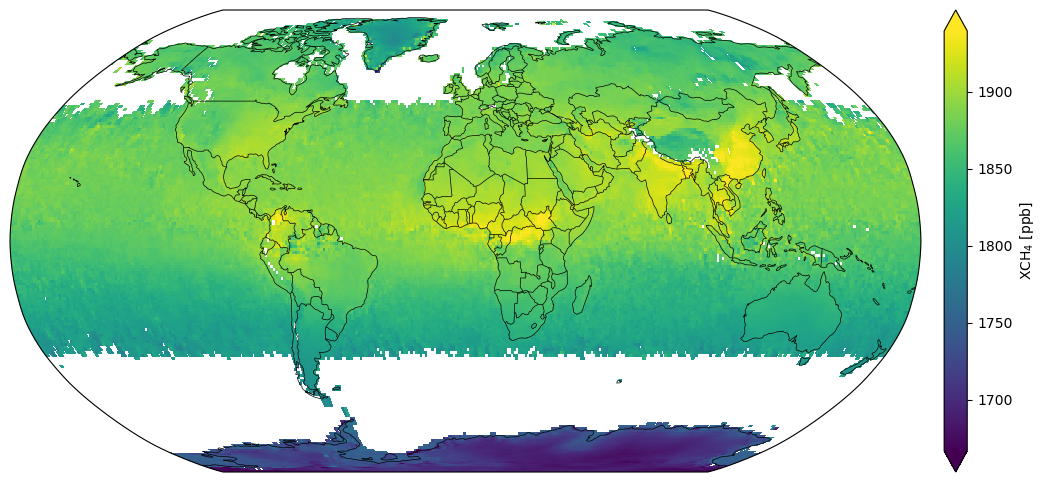

In [5]:
fig,ax = plt.subplots(figsize=(15,6), subplot_kw={"projection": ccrs.Robinson()})
vmin = np.nanpercentile(ds_mean["xch4"], 0.1)
vmax = np.nanpercentile(ds_mean["xch4"], 99.9)
ds_mean["xch4"].plot(ax=ax, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),
                     cbar_kwargs={"label":"XCH$_4$ [ppb]", "pad": 0.02})
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines(linewidth=0.5)

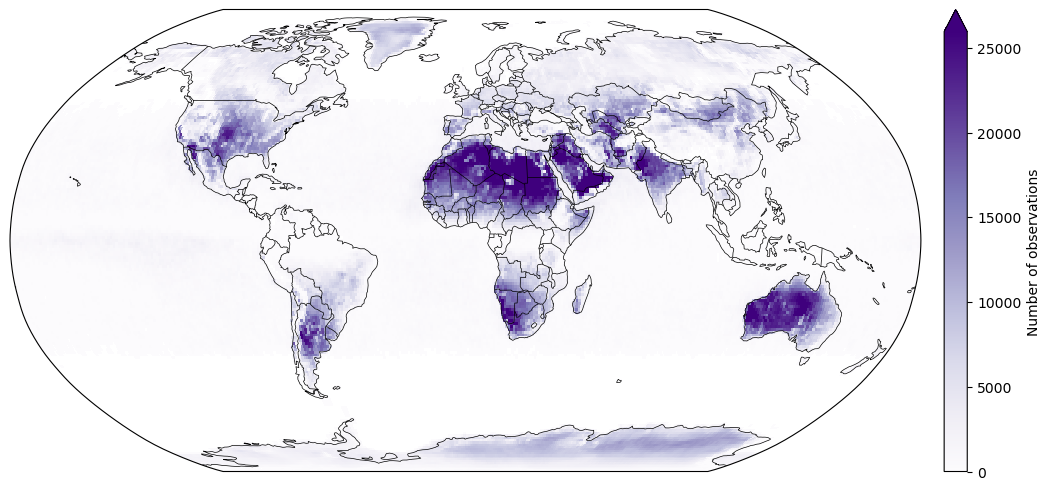

In [6]:
fig,ax = plt.subplots(figsize=(15,6), subplot_kw={"projection": ccrs.Robinson()})
vmax = np.nanpercentile(ds_count["xch4"], 99)
ds_count["xch4"].plot(ax=ax, vmin=0, vmax=vmax, cmap="Purples", transform=ccrs.PlateCarree(),
                      cbar_kwargs={"label":"Number of observations", "pad": 0.02})
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.coastlines(linewidth=0.5)